In [1]:
import numpy as np
import h5py
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import functions as fn
import box
import halo

In [2]:
plt.style.use(str(fn.HERE_PATH/'plot.mplstyle'))

In [3]:
redshifts = [3, 2, 1, 0]
x_bins = np.logspace(-2, np.log10(1), 21)
is_normalize = False
is_verbose = True

In [4]:
x = np.sqrt(x_bins[:-1]*x_bins[1:])

In [5]:
for z in redshifts:
    if is_verbose:
        print('--------------')
        print(f'z = {z}')
    boxes = np.array([])
    halos = np.array([])
    for model in fn.MODELS:
        model_path = fn.MODELS_PATH/model
        boxes = np.append(boxes, box.Box(model_path, fn.ZHOT[z]))
        fof_path = model_path/f'fof_subhalo_tab_{fn.ZHOT[z]}.hdf5'
        with h5py.File(fof_path) as fof:
            halo_masses = np.array(fof.get('Group/GroupMass'))
            ndx = np.array(np.where(halo_masses == np.amax(halo_masses)))[0]
            halo_pos = np.array(fof.get('Group/GroupPos'))[ndx]
            halo_r200c = np.array(fof.get('Group/Group_R_Crit200'))[ndx]
            
        halos = np.append(halos, halo.Halo(halo_pos, halo_r200c))
        
    if is_verbose:
        print('Calculating density profiles')

    [halo_i.get_density(boxes[i], x_bins) for i, halo_i in enumerate(halos)]

    with open(fn.HERE_PATH/'Mod_Density_Profiles'/f'total_z{z}.csv', 'w') as f:
        header = 'model,'
        for i in range(x.shape[0]):
            header += f'rho_{i},'
        header = header[:-1] + '\n'
        f.write(header)
        for i, model in enumerate(fn.MODELS):
            np.savetxt(f, np.hstack(([i], halos[i].density))[:,np.newaxis].T, delimiter=',')

--------------
z = 3
Calculating density profiles
--------------
z = 2
Calculating density profiles
--------------
z = 1
Calculating density profiles
--------------
z = 0
Calculating density profiles


--------------
z = 3
--------------
z = 2
--------------
z = 1
--------------
z = 0


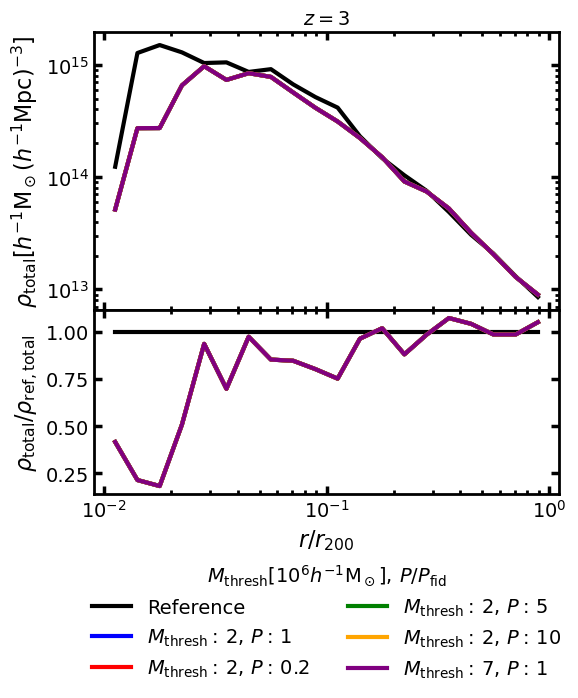

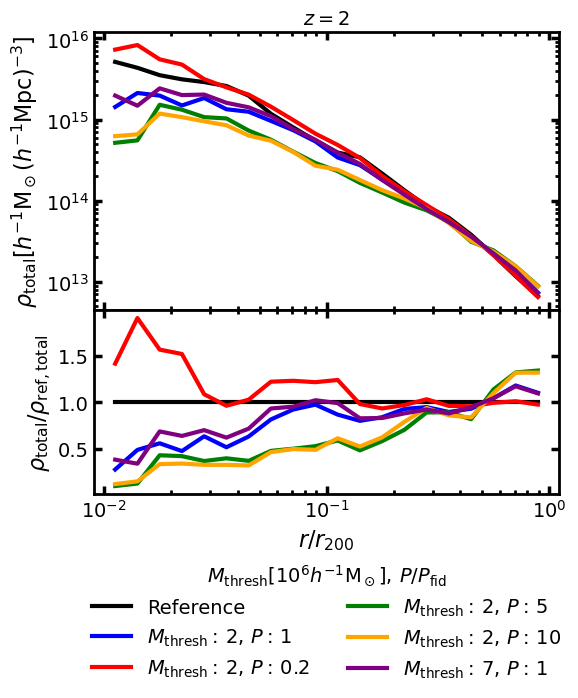

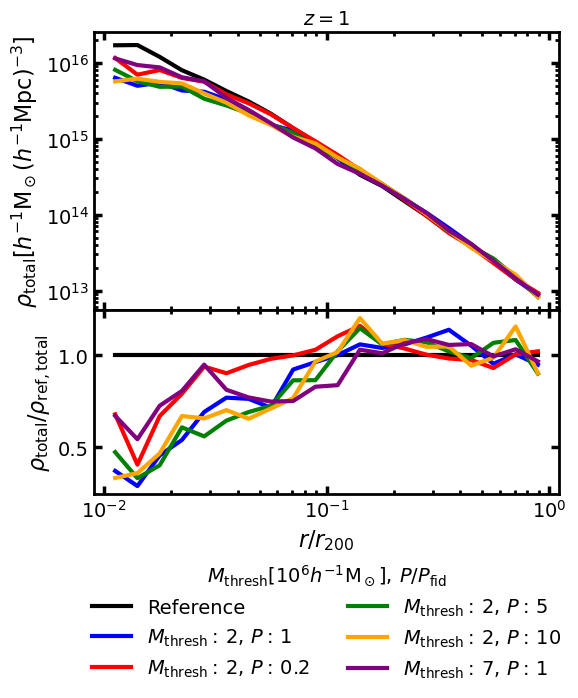

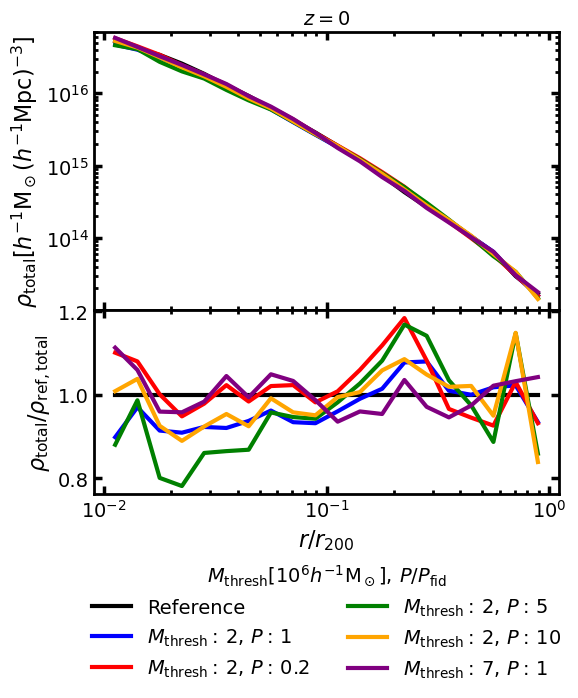

In [7]:
for z in redshifts:
    if is_verbose:
        print('--------------')
        print(f'z = {z}')

    df = pd.read_csv(fn.HERE_PATH/'Mod_Density_Profiles'/f'total_z{z}.csv')
    density = np.array(df.iloc[:,1:])
    halos = np.array([])

    for i in range(len(fn.MODELS)):
        halos = np.append(halos, halo.Halo(np.array([0, 0, 0]), 0))
        halos[-1].density = density[i, :]
    
    if is_normalize:
        for i, halo in halos:
            if fn.models[i] == 'REF':
                mass_ref = halo.mass
            halo.density *= mass_ref / halo.mass
    
    fg, ax = plt.subplots(2, gridspec_kw={'height_ratios':[3,2]})
    fg.subplots_adjust(hspace=0)
    ax[0].loglog()
    ax[1].semilogx()
    ax[0].xaxis.set_ticklabels([])
    ax[1].set_xlabel(r'$r/r_{200}$')
    ax[0].set_ylabel(r'$\rho_\mathrm{total} [h^{-1} \mathrm{M}_\odot (h^{-1} \mathrm{Mpc})^{-3}]$')
    ax[1].set_ylabel(r'$\rho_\mathrm{total}/\rho_\mathrm{ref, total}$', size=16)
    if is_normalize:
        ax[0].set_title(f'Normalized, $z={z}$')
    else:
        ax[0].set_title(f'$z={z}$')
        
    for i, halo_i in enumerate(halos):
        if fn.MODELS[i] == 'REF':
            density_ref = halo_i.density
            
        ax[0].plot(x, 1e10*halo_i.density, lw=3, c=fn.COLORS[fn.MODELS[i]], label=fn.LABELS[fn.MODELS[i]])
        ax[1].plot(x, halo_i.density/density_ref, lw=3, c=fn.COLORS[fn.MODELS[i]])
        
    ax[0].legend(bbox_to_anchor=(0.5, -1.4), loc='lower center', title=fn.LEGEND_TITLE, ncol=2)

    if z == 0:
        ax[0].set_ylim(1.01e13, 7e16)
    if is_normalize:
        fig_name = f'normalized_z{z}'
    else:
        fig_name = f'total_z{z}'

    fg.savefig(fn.HERE_PATH/'Total_Profiles'/f'{fig_name}.pdf', bbox_inches='tight')
    
    if z == 2 or z == 0:
        fg.savefig(fn.HERE_PATH/'Project_Plots'/f'total_z{z}.pdf', bbox_inches='tight')

In [ ]:
for model in fn.models:
    df = pd.read_csv(fn.here_path/'Density_Profiles'/f'{model}_z0.csv')
    print(np.log10(np.array(df.iloc[:,1])))
    print(np.log10(np.array(df.iloc[:,-1])))
    density = np.array(df.iloc[:,2:-1]).T
    if model == 'REF':
        dens_ref = density
    plt.semilogx(x, density/dens_ref)

In [ ]:
print(boxes[0].mass_dm)